In [8]:
import tensorflow as tf
from tensorflow import keras
import pathlib
import random
import os
import datetime
import time
from efficientnet.tfkeras import EfficientNetB1, preprocess_input

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

AUTOTUNE = tf.data.experimental.AUTOTUNE
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[3], True)
    except RuntimeError as e:
        print(e)


IndexError: list index out of range

In [6]:
dataset_name = 'em24'

train_dataset_path = '../datasets/emart24/cls_train/train'
valid_dataset_path = '../datasets/emart24/cls_train/validation'

BATCH_SIZE = 32
IMG_SIZE = 224
NUM_EPOCHS = 50
EARLY_STOP_PATIENCE = 5
TRAIN_STEP_PER_EPOCH = tf.math.ceil(train_images_len / BATCH_SIZE).numpy()
VALID_STEP_PER_EPOCH = tf.math.ceil(valid_images_len / BATCH_SIZE).numpy()

saved_path = '../em24_project/classification/model/'

time = datetime.datetime.now().strftime("%Y.%m.%d_%H:%M") + '_tf2'
weight_file_name = '{epoch:02d}-{val_accuracy:.2f}.hdf5'
checkpoint_path = saved_path + dataset_name + '/' + time + '/' + weight_file_name


if not(os.path.isdir(saved_path + dataset_name + '/' + time)):
    os.makedirs(os.path.join(saved_path + dataset_name + '/' + time))
else:
    pass

In [14]:
def basic_processing(img_path, is_training):
    img_path = pathlib.Path(img_path)

    images = list(img_path.glob('*/*'))
    images = [str(path) for path in images]
    len_images = len(images)

    if is_training:
        random.shuffle(images)

    labels = sorted(item.name for item in img_path.glob('*/') if item.is_dir())
    labels_len = len(labels)
    labels = dict((name, index) for index, name in enumerate(labels))
    labels = [labels[pathlib.Path(path).parent.name] for path in images]
    labels = tf.keras.utils.to_categorical(labels, num_classes=labels_len, dtype='float32')

    return images, labels, len_images, labels_len

def preprocess_image(image):
    #image = tf.image.decode_jpeg(image, channels=3)
    #image = tf.image.resize(image, [224, 224])
    #image = keras.applications.xception.preprocess_input(image)  ## 수정해야함

    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = preprocess_input(image)
    return image

# 이미지 path -> tensor
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    
    return preprocess_image(image)

# tf dataset 만들기
def make_tf_dataset(images, labels):
    image_ds = tf.data.Dataset.from_tensor_slices(images)
    image_ds = image_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

    lable_ds = tf.data.Dataset.from_tensor_slices(tf.cast(labels, tf.float32))

    image_label_ds = tf.data.Dataset.zip((image_ds, lable_ds))

    return image_label_ds

In [15]:
train_images, train_labels, train_images_len, train_labels_len = basic_processing(train_dataset_path, True)
valid_images, valid_labels, valid_images_len, valid_labels_len = basic_processing(valid_dataset_path, False)

In [16]:
train_ds = make_tf_dataset(train_images, train_labels)
valid_ds = make_tf_dataset(valid_images, valid_labels)

train_ds = train_ds.repeat().batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE) # tf.data.experimental.AUTOTUNE
valid_ds = valid_ds.repeat().batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
base_model = keras.applications.xception.Xception(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                                  weights="imagenet",
                                                  include_top=False)

avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(train_labels_len, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)


model = Sequential()
model.add(EfficientNetB0(include_top=False, pooling='avg', weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(Dense(len(CLASS_NAMES), activation='softmax'))
model.layers[0].trainable = True
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
base_model = EfficientNetB1(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                            weights="imagenet",
                            include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(train_labels_len, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)


for layer in base_model.layers:
    layer.trainable = True


LR_INIT = 0.000001
LR_MAX = 0.0002
LR_MIN = LR_INIT
RAMUP_EPOCH = 4
EXP_DECAY = 0.9

def lr_schedule_fn(epoch):
    if epoch < RAMUP_EPOCH:
        lr = (LR_MAX - LR_MIN) / RAMUP_EPOCH * epoch + LR_INIT
    else:
        lr = (LR_MAX - LR_MIN) * EXP_DECAY**(epoch - RAMUP_EPOCH)
    return lr    


#optimizer = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
optimizer = tf.keras.optimizers.Adam(LR_INIT)


#model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1, 
                                                           optimizer=optimizer, 
                                                           metrics=["accuracy"])



lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule_fn)
cb_early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
#checkpoint_path = saved_path + dataset_name + '/' + time + '/' + weight_file_name
cb_checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     monitor='val_accuracy',
                                                     save_best_only=True,
                                                     mode='auto')

In [18]:
history = model.fit(train_ds,
                    epochs=50,
                    steps_per_epoch=TRAIN_STEP_PER_EPOCH,
                    shuffle=False,
                    validation_data=valid_ds,
                    validation_steps=VALID_STEP_PER_EPOCH,
                    verbose=1,
                    callbacks=[cb_early_stopper, cb_checkpointer, lr_callback])

model.save(saved_path + dataset_name  + '/' + dataset_name + '.h5')

Train for 1480.0 steps, validate for 162.0 steps
Epoch 1/50
1480/1480 [==============================] - 414s 280ms/step - loss: 3.5314 - accuracy: 0.0518 - val_loss: 3.4011 - val_accuracy: 0.0899
Epoch 2/50
1480/1480 [==============================] - 401s 271ms/step - loss: 3.3075 - accuracy: 0.1421 - val_loss: 3.1432 - val_accuracy: 0.2562
Epoch 3/50
1480/1480 [==============================] - 402s 272ms/step - loss: 3.0511 - accuracy: 0.3044 - val_loss: 2.8305 - val_accuracy: 0.4585
Epoch 4/50
1480/1480 [==============================] - 402s 272ms/step - loss: 2.7355 - accuracy: 0.4842 - val_loss: 2.4505 - val_accuracy: 0.6316
Epoch 5/50
1480/1480 [==============================] - 403s 273ms/step - loss: 2.3751 - accuracy: 0.6321 - val_loss: 2.0435 - val_accuracy: 0.7523
Epoch 6/50
1480/1480 [==============================] - 403s 272ms/step - loss: 1.9984 - accuracy: 0.7384 - val_loss: 1.6450 - val_accuracy: 0.8360
Epoch 7/50
1480/1480 [==============================] - 403s 27

TypeError: can only concatenate str (not "module") to str

In [21]:
model.save(saved_path + dataset_name  + '/' + dataset_name + '.h5')

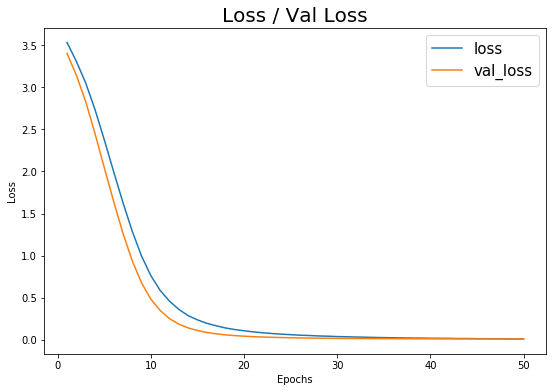

In [39]:
import numpy as np
epochs = 50

plt.figure(figsize=(9,6))
plt.plot(np.arange(1, epochs+1), history.history['loss'])
plt.plot(np.arange(1, epochs+1), history.history['val_loss'])
plt.title('Loss / Val Loss', fontsize = 20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'], fontsize=15)
plt.show()